In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

plt.style.use("../science.mplstyle")

from helpers.physics_functions import bkg_fit_cubic, bkg_fit_ratio, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio


In [72]:
pickle_save_dir = "pickles/mix_1_upsilon_iso_oppsign"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"

particle_type = "upsilon_iso"
particle_id = "upsilon"

if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"
    

    

In [73]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)   
    
SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])

# Plot histograms

In [74]:
with open(f"{pickle_save_dir}/fpr_thresholds", "rb") as ifile:
    fpr_thresholds = pickle.load(ifile)
with open(f"{pickle_save_dir}/all_test_data_splits", "rb") as ifile:
    all_test_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir}/all_alt_data_splits", "rb") as ifile:
    all_alt_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir}/all_scores_splits", "rb") as ifile:
    all_scores_splits = pickle.load(ifile)
with open(f"{pickle_save_dir}/all_alt_scores_splits", "rb") as ifile:
    all_alt_scores_splits = pickle.load(ifile)
with open(f"{pickle_save_dir}/score_cutoffs", "rb") as ifile:
    score_cutoffs = pickle.load(ifile)
      
        
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)

In [83]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "ratio": fit_function = bkg_fit_ratio

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right)


    plt.figure(figsize = (12, 9))
    for t, threshold in enumerate(fpr_thresholds):

        # corrections to SR / SB efficiencies
        filtered_masses = []

        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)

        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
        #print("chi2/dof:", chi2/n_dof)
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sum(y_err)

        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


    plt.legend(loc = (1, 0), fontsize = 24)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
    plt.ylabel("Counts", fontsize = 24)

    plt.title(title, fontsize = 24)
    


In [84]:
pseudo_e_to_plot = 0
fit_type = "cubic"

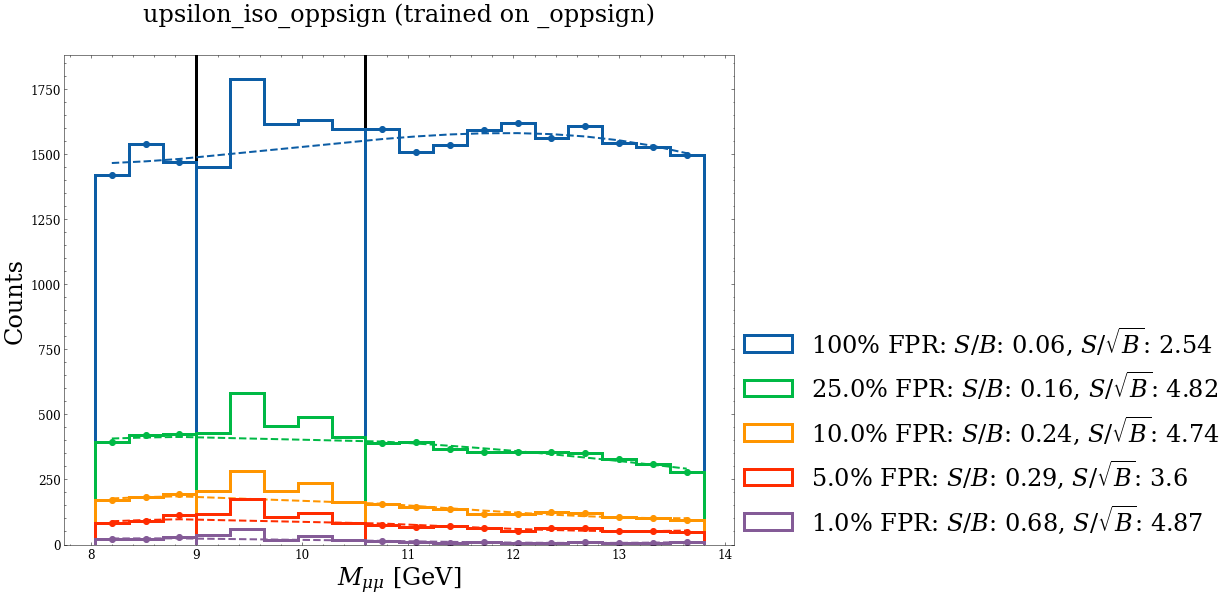

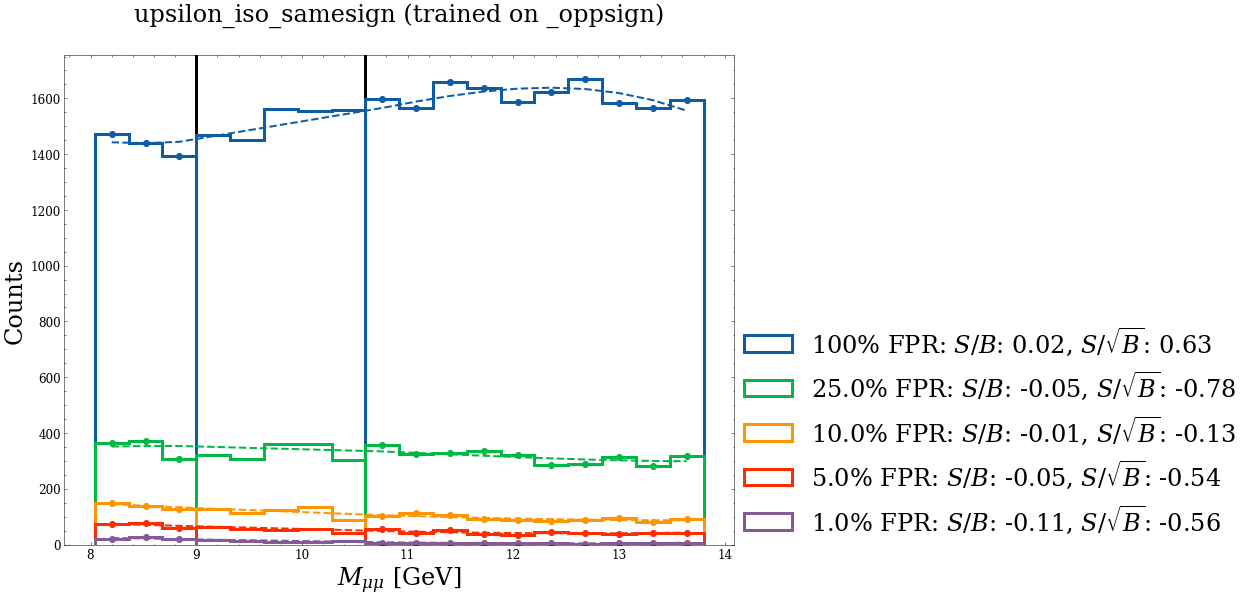

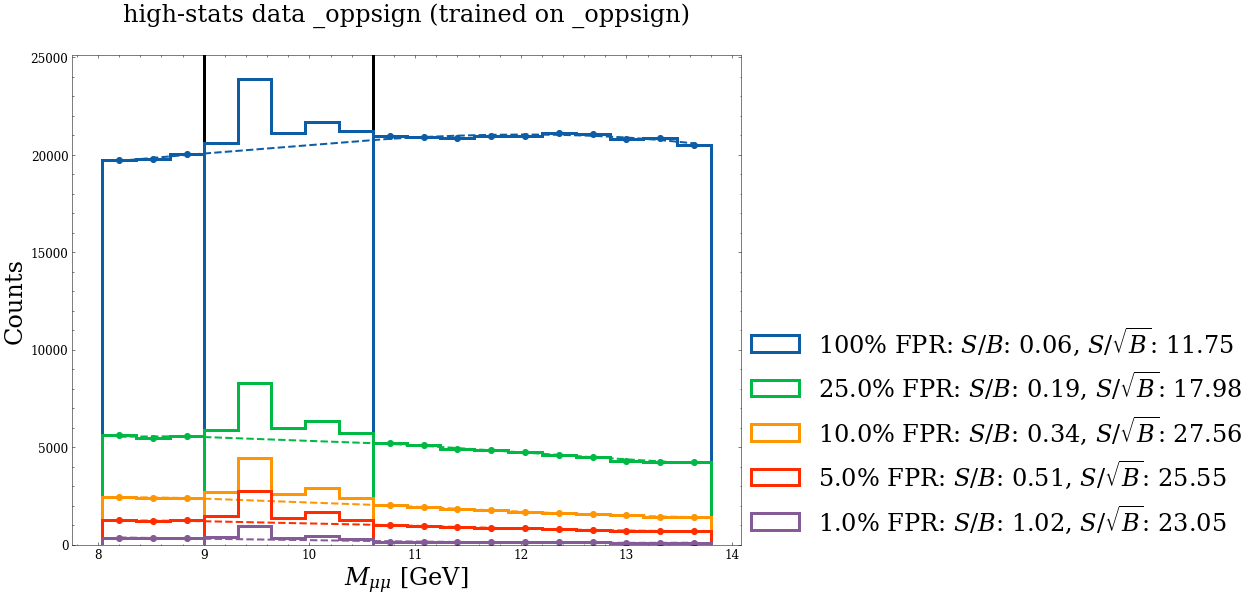

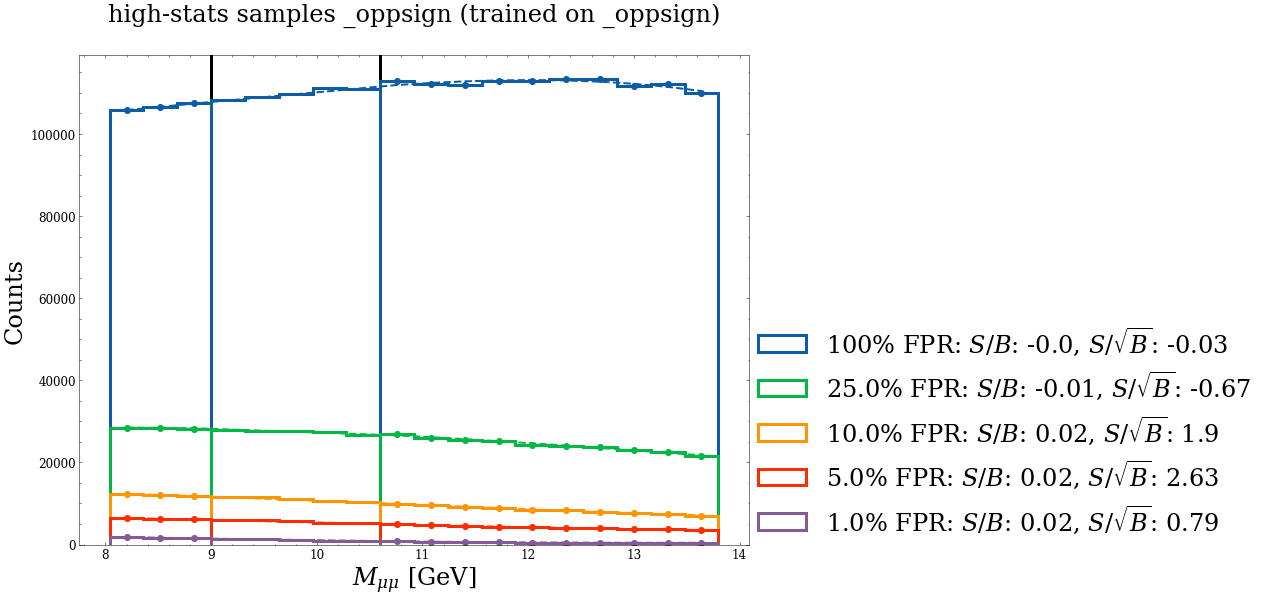

In [85]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



# Plot ROC

In [81]:
from helpers.evaluation import get_median_percentiles


NameError: name 'get_classifier_metrics_high_stats' is not defined

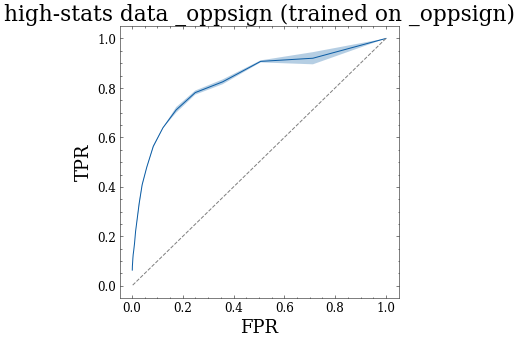

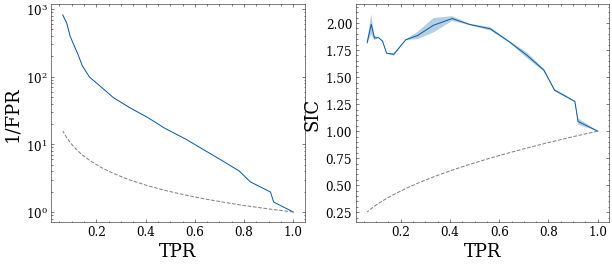

In [86]:
with open(f"{pickle_save_dir}/TPR", "rb") as ifile:
    TPR = pickle.load(ifile)
with open(f"{pickle_save_dir}/FPR", "rb") as ifile:
    FPR = pickle.load(ifile)
with open(f"{pickle_save_dir}/ROC", "rb") as ifile:
    ROC = pickle.load(ifile)
with open(f"{pickle_save_dir}/SIC", "rb") as ifile:
    SIC = pickle.load(ifile)


     
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

plt.figure(figsize = (5, 5))
plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )
plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"high-stats data _oppsign (trained on {train_data_id_title})")


fig, ax = plt.subplots(1, 2, figsize = (10, 4))


ax[0].plot(TPR_median, ROC_median)
ax[0].fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax[0].plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax[0].set_xlabel("TPR")
ax[0].set_ylabel("1/FPR")
ax[0].set_yscale("log")

ax[1].plot(TPR_median, SIC_median)
ax[1].fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3 )
ax[1].plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax[1].set_xlabel("TPR")
ax[1].set_ylabel("SIC")



TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats("ROC_samples", score_cutoffs_finegrained)

     
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

plt.figure(figsize = (5, 5))
plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )
plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.title(f"{train_data_id_title} high-stats samples (trained on {train_data_id_title})")


fig, ax = plt.subplots(1, 2, figsize = (10, 4))


ax[0].plot(TPR_median, ROC_median)
ax[0].fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax[0].plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax[0].set_xlabel("TPR")
ax[0].set_ylabel("1/FPR")
ax[0].set_yscale("log")

ax[1].plot(TPR_median, SIC_median)
ax[1].fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3 )
ax[1].plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax[1].set_xlabel("TPR")
ax[1].set_ylabel("SIC")


